# Set up Kaggle environment

In [49]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [51]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [52]:
!chmod 600 ~/.kaggle/kaggle.json

In [53]:
!kaggle competitions download -c fall-ml2-mipt-2023

fall-ml2-mipt-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


In [54]:
!mkdir data
!unzip fall-ml2-mipt-2023.zip -d data

mkdir: cannot create directory ‘data’: File exists
Archive:  fall-ml2-mipt-2023.zip
replace data/sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/sample.csv         
replace data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/test.csv           
replace data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/train.csv          


# Set up Python environment

In [55]:
!wget -q -O requirements.txt https://raw.githubusercontent.com/Ark3M/Machine_Learning_MIPT/main/Homework_2/requirements.txt
!pip install -q -r requirements.txt

In [56]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import seaborn as sns

import catboost
from catboost import CatBoostRegressor

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import (train_test_split, KFold, ParameterGrid,
                                     GridSearchCV)
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

import skfda
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.ml.regression._kernel_regression import KernelRegression

import time

from tqdm.notebook import tqdm

import random
random.seed(42)
np.random.seed(42)

In [57]:
print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("SciPy version:", scipy.__version__)
print("seaborn version:", sns.__version__)
print("CatBoost version:", catboost.__version__)
print("scikit-learn version:", sklearn.__version__)
print("scikit-fda version:", skfda.__version__)

NumPy version: 1.23.5
Matplotlib version: 3.7.1
pandas version: 1.5.3
SciPy version: 1.11.3
seaborn version: 0.12.2
CatBoost version: 1.2.2
scikit-learn version: 1.2.2
scikit-fda version: 0.9


In [58]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")

In [59]:
train_data.sample(5, random_state=42)

,Id,Category,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
7940,7940,4028.882529,0.352920,1.260915,-0.508886,-1.394332,0.885294,-0.028402,-0.641132,-0.674614,...,-0.605543,0.664190,-0.692197,1.366601,-1.824016,-0.092725,-1.300171,-1.271644,1.738578,-0.527962
1162,1162,4105.986328,0.126077,-0.271997,-0.434776,-1.156804,-0.086839,0.069909,0.564491,1.306464,...,-0.523530,-1.892023,1.279750,0.849509,1.032702,0.289172,-0.129430,-0.198659,-1.935958,-0.499715
582,582,1252.434197,0.363228,0.567714,1.248946,-0.196409,0.699300,-0.322962,0.226045,0.913468,...,0.902034,-1.177415,0.166688,-0.336547,-1.783695,1.360798,-0.648645,0.443763,1.243612,-1.127115
4081,4081,2724.977260,1.420555,-0.856992,-0.326628,0.298690,0.232530,0.967905,0.123713,-0.565374,...,-0.869516,1.490169,0.722783,1.331582,0.939452,0.102805,0.640172,-0.771826,-1.169283,1.150417
8412,8412,5087.338997,0.649049,0.663989,-0.423261,-0.811215,0.713595,0.059118,0.507625,-0.469708,...,2.242312,-0.158805,0.360351,-0.332395,-0.591154,0.705706,0.921269,0.348800,-0.531707,-0.249947


In [60]:
test_data.sample(5, random_state=42)

,Id,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_91,x_92,x_93,x_94,x_95,x_96,x_97,x_98,x_99,x_100
521,521,0.871480,-0.440390,0.917776,-0.296730,-0.109325,-0.369024,-0.819836,0.805594,-1.210785,...,-0.089296,-1.229797,-0.739756,0.947265,-0.499986,-1.795198,1.279436,0.331342,-1.055002,0.047369
737,737,2.653461,1.314795,-2.015366,-1.687538,-0.645912,-0.442693,0.198743,0.410841,-0.400919,...,2.787543,-0.569256,0.052537,0.821303,-1.192334,-2.140077,-0.933828,0.485053,-1.508946,0.829323
740,740,0.027987,-0.575459,-2.838324,0.366966,0.398979,-0.343206,-1.406724,-0.566458,-0.798880,...,-0.609969,-2.157048,-0.257779,1.192419,0.212557,0.290195,1.023893,1.690297,1.311897,0.438899
660,660,0.783134,-1.417902,-0.110048,1.290081,0.246412,0.951527,-0.309869,-0.366925,0.097801,...,-0.444004,-0.010123,0.170862,-0.643833,0.573887,1.418230,1.680601,0.290421,1.203355,0.215601
411,411,1.520526,0.049583,-0.049050,0.262049,-0.591740,-0.490437,1.190732,-1.152903,1.028219,...,0.488817,0.447563,2.301727,-1.314749,1.835680,-0.544684,-0.064527,-1.704101,-1.309753,1.662258


# Data Preparation

In [61]:
target = "Category"

In [62]:
X = train_data.drop(columns=target, axis=1)
y = train_data[target]
print("X:", X.shape, "\t", type(X))
print("y:", y.shape, "\t", type(y))

X: (9000, 101) 	 <class 'pandas.core.frame.DataFrame'>
y: (9000,) 	 <class 'pandas.core.series.Series'>


In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15,
                                                      random_state=42)

In [64]:
print(train_data[target].describe())

count    9000.000000
mean     2172.374204
std      1815.552523
min        43.481937
25%       677.899261
50%      1396.503952
75%      3203.820841
max      9300.641194
Name: Category, dtype: float64


Skewness: 1.04391975651334
Kurtosis: 0.1877768209413504


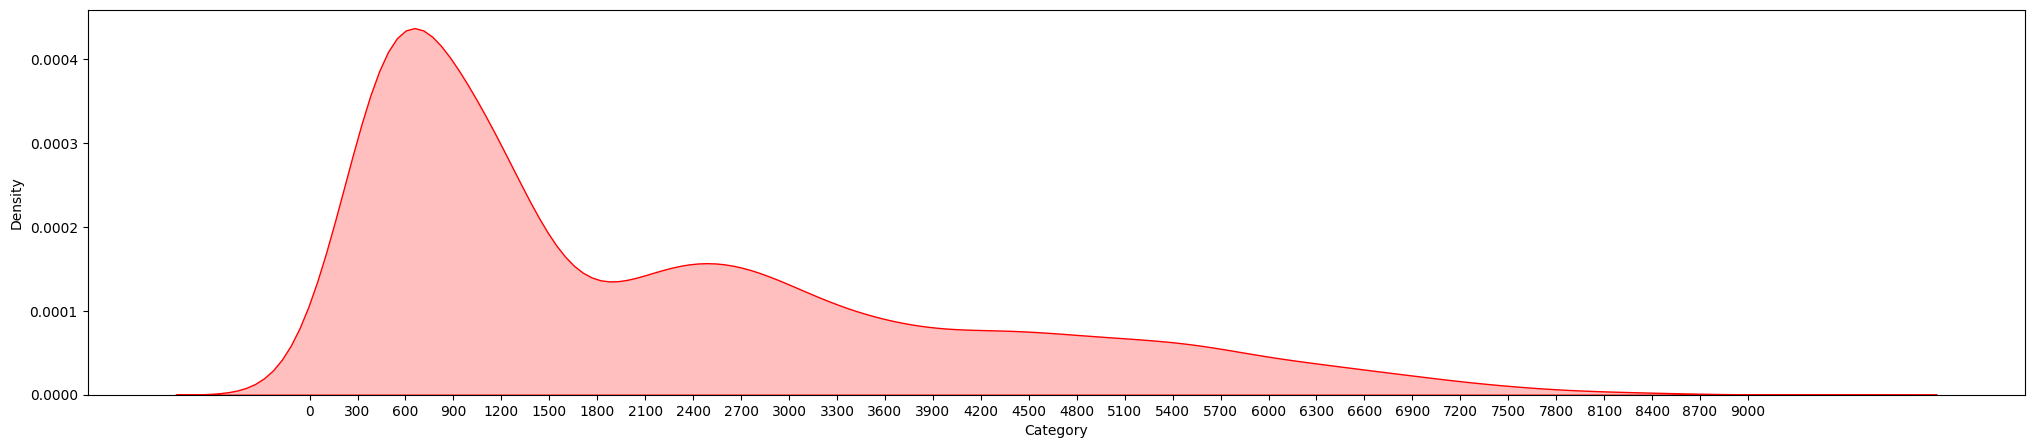

In [65]:
plt.figure(figsize=(25, 5))
print("Skewness:", train_data[target].skew())
print("Kurtosis:", train_data[target].kurtosis())
sns.kdeplot(train_data[target], fill=True, color="red")
plt.xticks([i for i in range(0, 9300, 300)])
plt.show()

# CatBoost Regression

In [66]:
regressors = {
    "CatBoost": CatBoostRegressor(random_state=42, verbose=False)
}

In [21]:
boosting_grid = {'iterations': [100],
        'learning_rate': [0.05, 0.1, 0.15],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

grid = {
    "CatBoost": boosting_grid}

In [23]:
i = 0
reg_best_params = regressors.copy()
valid_scores = pd.DataFrame({"Classifier": regressors.keys(),
                             "Validation accuracy": np.zeros(len(regressors))})

for key, regressor in regressors.items():
    reg = GridSearchCV(estimator=regressor, param_grid=grid[key], n_jobs=-1,
                       cv=None)

    # Train and score.
    reg.fit(X_train, y_train)
    valid_pred = reg.predict(X_valid)
    valid_scores.iloc[i, 1] = mean_squared_error(y_true=y_valid,
                                                 y_pred=valid_pred,
                                                 squared=False)

    # Save trained model.
    reg_best_params[key] = reg.best_params_

    i += 1

In [24]:
print(valid_scores)

  Classifier  Validation accuracy
0   CatBoost           1803.69145


In [78]:
print(reg_best_params)

{'CatBoost': {'depth': 2, 'iterations': 100, 'l2_leaf_reg': 0.2, 'learning_rate': 0.15}}


In [79]:
best_regressors = {
    "CatBoost": CatBoostRegressor(**reg_best_params["CatBoost"], verbose=False,
                                  random_state=42)
}

In [80]:
# Number of folds in cross validation
folds = 10

preds = np.zeros(len(test_data))

for key, regressor in best_regressors.items():
    start = time.time()

    cv = KFold(n_splits=folds, shuffle=True, random_state=42)
    score = 0

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets.
        X_train, X_valid = X.loc[train_idx], X.loc[val_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[val_idx]

        valid_preds = np.zeros(len(X_valid))

        reg = regressor
        reg.fit(X_train, y_train)

        preds += reg.predict(test_data)
        valid_preds += reg.predict(X_valid)

        score += mean_squared_error(y_true=y_valid, y_pred=valid_preds,
                                                 squared=False)

    score = score / folds  # Average RMSE.
    stop = time.time()

    print("Model:", key)
    print("Average validation RMSE:", np.round(score, 2))
    print("Training time (minutes):", np.round((stop - start) / 60, 2))
    print("")

# Ensemble predictions.
preds = preds / (folds * len(best_regressors))

Model: CatBoost
Average validation RMSE: 1793.27
Training time (minutes): 0.12



In [74]:
# Sample submission.
submission = pd.read_csv("./data/sample.csv")

# Add predictions.
submission["Category"] = preds

submission.to_csv("submission.csv", index=False)